- Ligne transport
    <https://public.opendatasoft.com/explore/dataset/ligne-transport/table/?location=11,48.87194,2.60376&basemap=mb-931882>

- Decomposing trend, seasonal and residual time series elements
    <https://stackoverflow.com/questions/34457281/decomposing-trend-seasonal-and-residual-time-series-elements>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
from datetime import datetime, date
import math
import matplotlib
import matplotlib.pyplot as plt

import geopandas
import branca.colormap as cm
import folium
from folium import plugins

In [2]:
vf = pd.read_csv('downloads/idf.1419.csv')
vf_75 = vf[vf['code_departement'] == 75]

communesidf_geo = geopandas.read_file('downloads/Communes_IDF.json', driver='JSON')
dept_geo = geopandas.read_file('downloads/departements.geojson', driver='GeoJSON')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (14,16,17,18,20,22,24,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
communes75_geo = communesidf_geo[(communesidf_geo['C_INSEE']>=75000) &
                                 (communesidf_geo['C_INSEE']<76000) &
                                 (communesidf_geo['B_BOIS']=='Non')]
communes75_bois_geo = communesidf_geo[(communesidf_geo['C_INSEE']>=75000) &
                                      (communesidf_geo['C_INSEE']<76000) &
                                      (communesidf_geo['B_BOIS']=='Oui')]
dept75_geo = dept_geo[dept_geo['code']=='75']

In [4]:
def calculate_vf_m2(nature_culture, valeur_fonciere, surface_terrain, surface_reelle_bati):
    if math.isnan(surface_terrain) == False and nature_culture in ['sols', 'jardins', "terrains d'agrément"]:
        return valeur_fonciere / surface_terrain
    else:
        return valeur_fonciere / surface_reelle_bati

def grp_nbpiece(piece):
    if piece == 0 or piece > 4:
        return 'Others'
    else:
        return 'T%d' % int(piece)

In [5]:
vf_75 = vf_75[(vf_75['type_local'] == 'Appartement') &
              (vf_75['nature_mutation'] == 'Vente') &
              (vf_75['valeur_fonciere'] > 0) &
              (vf_75['surface_reelle_bati'] > 0) &
              (vf_75['longitude'].isnull() == False) &
              (vf_75['latitude'].isnull() == False) &
              ((vf_75['lot1_numero'].notnull()) |
               (vf_75['lot1_surface_carrez'].notnull()) |
               (vf_75['lot2_surface_carrez'].notnull()) |
               (vf_75['lot3_surface_carrez'].notnull()) |
               (vf_75['lot4_surface_carrez'].notnull()) |
               (vf_75['lot5_surface_carrez'].notnull()) )]
vf_75 = vf_75[[
    'id_mutation',
    'date_mutation',
    'numero_disposition',
    'nature_mutation',
    'valeur_fonciere',
    'adresse_numero',
    'adresse_suffixe',
    'adresse_nom_voie',
    'adresse_code_voie',
    'code_postal',
    'code_commune',
    'nom_commune',
    'code_departement',
    'type_local',
    'nature_culture',
    'surface_terrain',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'longitude',
    'latitude'
]]

vf_75 = vf_75.drop_duplicates(['id_mutation'], keep=False)
vf_75['nb_piece_group'] = vf_75['nombre_pieces_principales'].map(grp_nbpiece)
vf_75['valeur_m2'] = vf_75.apply(lambda row: calculate_vf_m2(row['nature_culture'], row['valeur_fonciere'],
                                                             row['surface_terrain'], row['surface_reelle_bati']),
                                 axis='columns')
vf_75['valeurK_m2'] = vf_75['valeur_m2'] / 1000
vf_75.reset_index(drop=True, inplace=True)

In [6]:
vf_75.date_mutation = vf_75.date_mutation.apply(lambda s: datetime.strptime(s, '%Y-%m-%d'))
vf_75['Year'] = vf_75.date_mutation.apply(lambda d: d.strftime('%Y'))
vf_75['Month'] = vf_75.date_mutation.apply(lambda d: date(d.year, d.month, 1))

In [7]:
vf_75.head(2)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,type_local,nature_culture,surface_terrain,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,nb_piece_group,valeur_m2,valeurK_m2,Year,Month
0,2014-1054425,2014-01-09,1,Vente,1250000.0,19.0,NaN,RUE DU COLISEE,2185,75008.0,75108,Paris 8e Arrondissement,75,Appartement,NaN,nan,114.0,4.0,2.3,48.9,T4,10964.9,11.0,2014,2014-01-01
1,2014-1054427,2014-01-03,1,Vente,366300.0,39.0,NaN,RUE DE MOSCOU,6573,75008.0,75108,Paris 8e Arrondissement,75,Appartement,NaN,nan,28.0,2.0,2.3,48.9,T2,13082.1,13.1,2014,2014-01-01


In [8]:
mth_amount_df = vf_75.groupby(['Month'])['id_mutation'].count().to_frame().reset_index()
mth_amount_df = mth_amount_df.rename(columns={'id_mutation':'nb_mutation'})
mth_avgprc_df = vf_75.groupby(['Month'])['valeurK_m2'].mean().to_frame().reset_index()
mth_avgprc_df = mth_avgprc_df.rename(columns={'valeurK_m2':'avg_valeurK_m2'})
mth_df = pd.merge(mth_amount_df, mth_avgprc_df, on='Month')

## Visu tools

In [10]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

YEARS = mdates.YearLocator()
YEARFMT = mdates.DateFormatter('%Y')
MONTHS = mdates.MonthLocator()

def thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

def thousands_1dec(x, pos):
    return '%1.1f' % (x * 1e-3)

def millions_1dec(x, pos):
    return '%1.1f' % (x * 1e-6)

formatter_thousands = FuncFormatter(thousands)
formatter_thousands_1dec = FuncFormatter(thousands_1dec)
formatter_millions_1dec = FuncFormatter(millions_1dec)

In [11]:
def autolabel_simple_barplot(ax, rects, color):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height().round(2).astype(float)
        ax.text(rect.get_x() + rect.get_width() / 2.,
                3 + height,
                '%1.1f' % height,
                fontsize=11, ha='center', va='center', color=color)


def autolabel_simple_keuros_barplot(ax, rects, color):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height().round(2).astype(float)
        ax.text(rect.get_x() + rect.get_width() / 2.,
                0.2 + height,
                '%1.2fk€' % height,
                fontsize=11, ha='center', va='center', color=color)

def autolabel_simple_thousands_barplot(ax, rects, color):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height().round(2).astype(float)
        ax.text(rect.get_x() + rect.get_width() / 2.,
                200 + height,
                '%1.1f' % (height * 1e-3),
                fontsize=11, ha='center', va='center', color=color)


## Time series: monthly average price per m2 & monthly transaction amount

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


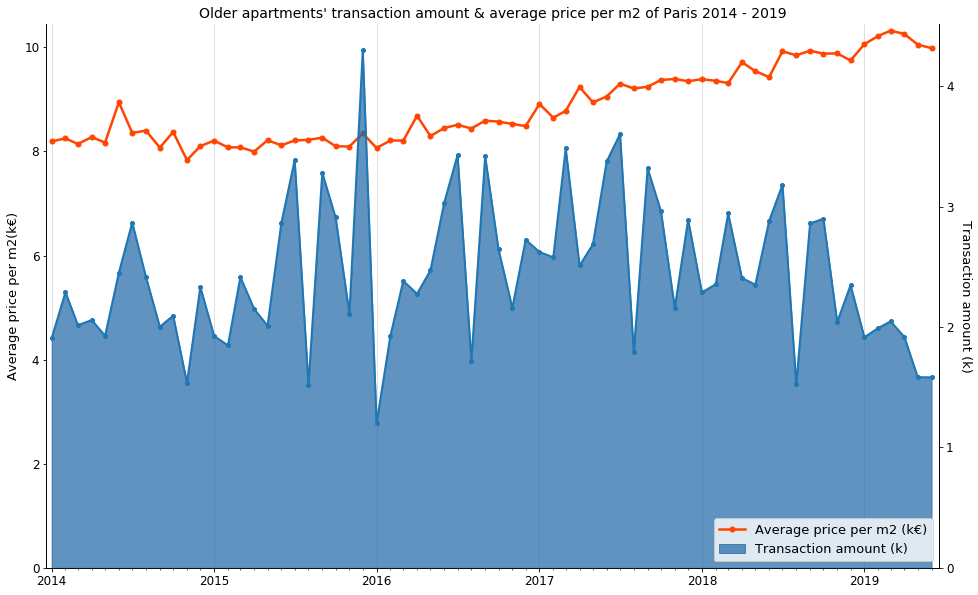

In [12]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
ax1.set_title('Older apartments\' transaction amount & average price per m2 of Paris 2014 - 2019',
              fontdict={'fontsize': 14})

line_price, = ax1.plot(mth_df.Month,
                       mth_df.avg_valeurK_m2,
                       marker='.',
                       linewidth=2.5,
                       markersize=10,
                       color='orangered')

ax1.tick_params(labelsize=12)
ax1.set_xticks(mth_df.Month)
ax1.set_xlim(left=date(2013, 12, 20), right=date(2019, 6, 18))
ax1.set_ylim(bottom=0)
ax1.set_ylabel('Average price per m2(k€)', size=13)

ax1.xaxis.set_major_locator(YEARS)
ax1.xaxis.set_minor_locator(MONTHS)
ax1.xaxis.set_major_formatter(YEARFMT)
ax1.grid(axis='x', which='major', alpha=0.5)
ax1.spines['top'].set_visible(False)

ax_02 = ax1.twinx()
area_txamt = ax_02.fill_between(mth_df.Month,
                                mth_df.nb_mutation,
                                alpha=0.7,
                                color='#1D65A6')
ax_02.plot(mth_df.Month,
           mth_df.nb_mutation,
           linewidth=2,
           marker='.',
           markersize=8)

ax_02.tick_params(labelsize=12)
ax_02.set_ylim(bottom=0)
ax_02.spines['top'].set_visible(False)
ax_02.yaxis.set_major_formatter(formatter_thousands)
ax_02.set_ylabel('Transaction amount (k)', rotation=270, labelpad=18, size=13)
ax_02.legend(handles=(line_price, area_txamt),
             fontsize=13,
             labels=('Average price per m2 (k€)', 'Transaction amount (k)'), loc=4)

plt.show()
# plt.savefig('transaction_amount_unit_price_1419.png', bbox_inches='tight')

This graph describes older apartments' transaction amount and average price per m2 of Paris, between January 2014 and June 2019. The orange line shows the monthly avergage price per m2, the blue area displays the monthly transaction amount. During 5.5 years, the average price per m2 increases 32%(10.3/7.8 - 1), especially from the year 2017, the average price per m2 increases nearly 20% (10.3/8.6 - 1). Moreover, the transaction amount arrives the yearly lowest point in August, which might because people go on holiday at that time; on the contrary, the transactions in July or September are higher than other months, which means that people usually sign the purchase promise in May or July (supposed that we have 2 months for negotiating the credit between the purchase promise and purchase agreement), so that they can sign the agreement before their holiday or before the school opening.

## Per nb piece: average price per m2 & transaction amount

In [13]:
nbpiece_tot_txamt = vf_75.groupby(['nb_piece_group'])['id_mutation'].count().to_frame().reset_index()
nbpiece_tot_txamt = nbpiece_tot_txamt.rename(columns={'id_mutation':'nb_transaction'})
nbpiece_tot_txamt['QP'] = nbpiece_tot_txamt['nb_transaction'] / nbpiece_tot_txamt['nb_transaction'].sum()

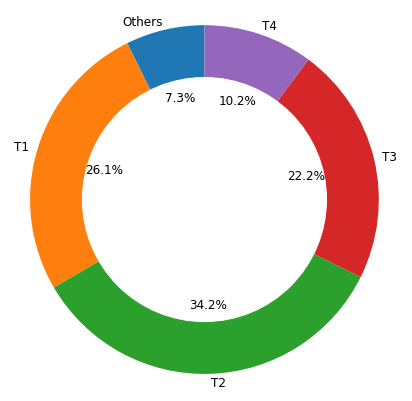

In [14]:
plt.figure(figsize=(7, 7))

my_circle = plt.Circle((0, 0), 0.7, color='white')
d = plt.pie(nbpiece_tot_txamt['QP'],
            labels=nbpiece_tot_txamt['nb_piece_group'],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.05)
plt.axis('equal')
plt.gca().add_artist(my_circle)

for i, (Others, T1, T2, T3, T4) in enumerate(d):
    if i > 0:
        Others.set_fontsize(12)
        T1.set_fontsize(12)
        T2.set_fontsize(12)
        T3.set_fontsize(12)
        T4.set_fontsize(12)

plt.show()
# plt.savefig('quotepart_piece_number.png', bbox_inches='tight')

This donut chart describes the quote-part of different pieces' apartment among the transactions. T1 and T2 hold 60% transactions, 22% transactions sold T3 apartments, other purchases are for larger apartments. Let's go further on the details.

In [15]:
nbpiece_df = vf_75.groupby(['nb_piece_group'])['surface_reelle_bati', 'valeurK_m2'].mean().reset_index()
nbpiece_df = nbpiece_df.reindex([1, 2, 3, 4, 0])

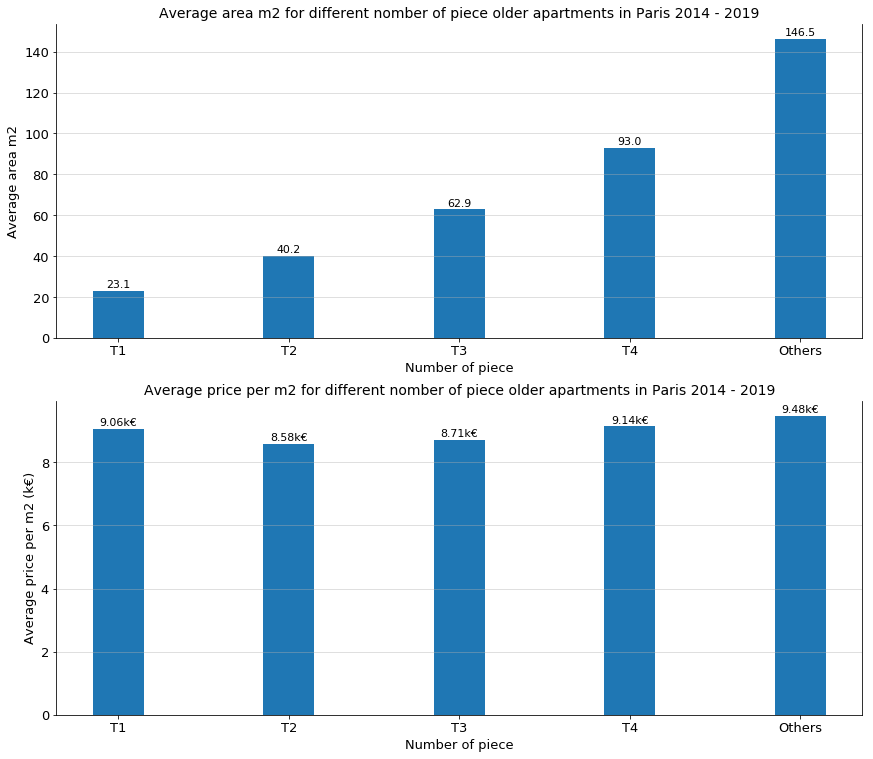

In [16]:
width = 0.3

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))
ax[0].set_title('Average area m2 for different nomber of piece older apartments in Paris 2014 - 2019',
                fontdict={'fontsize': 14})
rects1 = ax[0].bar(nbpiece_df.nb_piece_group,
                nbpiece_df.surface_reelle_bati,
                width)

ax[0].tick_params(labelsize=13)
ax[0].set_xlabel('Number of piece', size=13)
ax[0].set_ylabel('Average area m2', size=13)

ax[0].grid(axis='y', which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)
autolabel_simple_barplot(ax[0], rects1.patches, 'k')

ax[1].set_title('Average price per m2 for different nomber of piece older apartments in Paris 2014 - 2019',
                fontdict={'fontsize': 14})
rects2 = ax[1].bar(nbpiece_df.nb_piece_group,
                nbpiece_df.valeurK_m2,
                width)

ax[1].tick_params(labelsize=13)
ax[1].set_xlabel('Number of piece', size=13)
ax[1].set_ylabel('Average price per m2 (k€)', size=13)

ax[1].grid(axis='y', which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)
autolabel_simple_keuros_barplot(ax[1], rects2.patches, 'k')

plt.subplots_adjust(hspace=0.2, top=0.9, bottom=0.1, left=0.1, right=0.9)

plt.show()
# plt.savefig('unit_price_piece_number.png', bbox_inches='tight')

This graph describes the average price m2 for different nomber of piece older apartments in Paris, between January 2014 and June 2019. I classed older apartments into 5 groups in terms of piece's number: T1, which means one-room apartment with around 23 m2; T2, which means two-rooms apartment with around 40 m2; T3 presents three-room apartment around 63 m2; T4 are four-room apartments nearly 93 m2; T5 are five-room apartments with larger area about 147 m2. According to the second graph, we find that although T2 and T3 are much larger than T1, their unit prices are 5.5% and 4% lower than the unit price of T1. Moreover, average area of T4 is three times larger than T1, its unit price is only 1% more expensive than T1; similar for other piece-nomber apartments. Why are T1 apartments that expensive per m2? That might because there are many students or young workers in Paris, they need rent a big enough apartment, which makes investors to invest T1 apartments, it also leads higher demands on T1.

## Time series: Per nb piece - average price per m2 & transaction amount

In [17]:
yr_nbpiece_amt = vf_75.groupby(['Year', 'nb_piece_group'])['id_mutation'].count().to_frame().reset_index()
yr_nbpiece_amt = yr_nbpiece_amt.rename(columns={'id_mutation':'nb_transaction'})

yr_nbpiece_avgprice = vf_75.groupby(['Year', 'nb_piece_group'])['valeurK_m2'].mean().to_frame().reset_index()
yr_nbpiece_avgprice = yr_nbpiece_avgprice.rename(columns={'valeurK_m2':'avg_valeurK_m2'})

yr_nbpiece_m2 = vf_75.groupby(['Year', 'nb_piece_group'])['surface_reelle_bati'].mean().to_frame().reset_index()
yr_nbpiece_m2 = yr_nbpiece_m2.rename(columns={'surface_reelle_bati':'avg_surface_reelle_bati'})

yr_nbpiece_df = pd.merge(yr_nbpiece_amt,
                         yr_nbpiece_m2,
                         on=['Year', 'nb_piece_group'])
yr_nbpiece_df = pd.merge(yr_nbpiece_df,
                         yr_nbpiece_avgprice,
                         on=['Year', 'nb_piece_group'])

In [18]:
yr_nbpiece_val_pvtbl = pd.pivot_table(data=yr_nbpiece_df,
                                      index='Year',
                                      columns='nb_piece_group',
                                      values='avg_valeurK_m2').reset_index()
yr_nbpiece_val_pvtbl.Year = yr_nbpiece_val_pvtbl.Year.map(int)

yr_nbpiece_m2_pvtbl = pd.pivot_table(data=yr_nbpiece_df,
                                     index='Year',
                                     columns='nb_piece_group',
                                     values='avg_surface_reelle_bati').reset_index()
yr_nbpiece_m2_pvtbl.Year = yr_nbpiece_m2_pvtbl.Year.map(int)

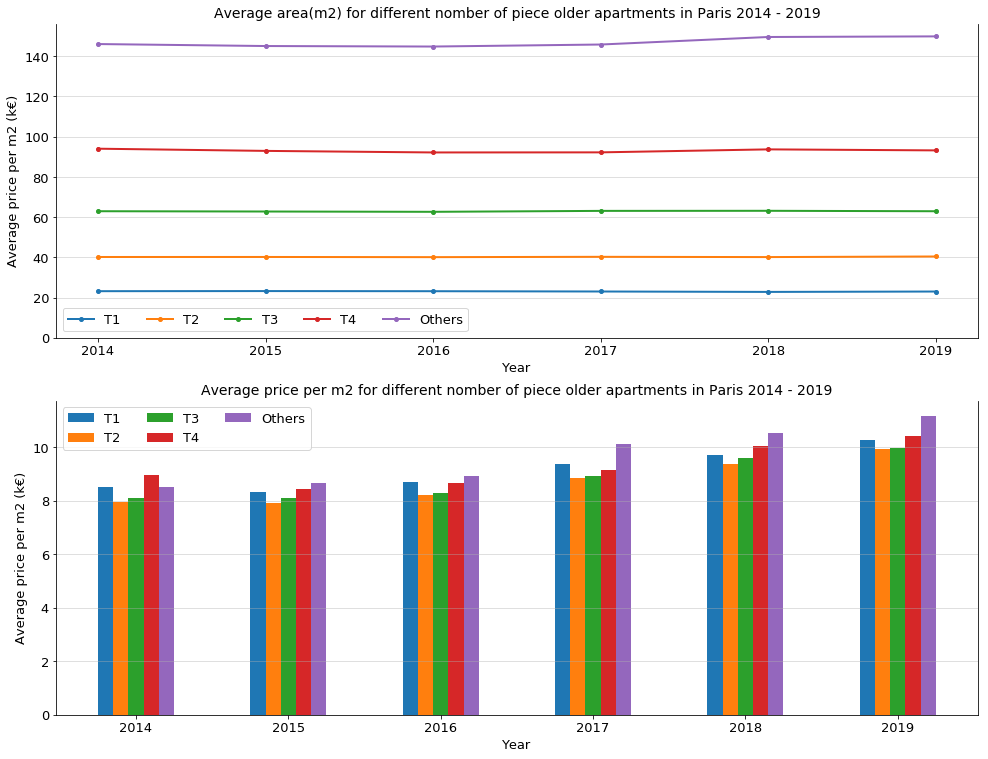

In [19]:
width = 0.1

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
ax[0].set_title('Average area(m2) for different nomber of piece older apartments in Paris 2014 - 2019',
                fontdict={'fontsize': 14})
surface_t1, = ax[0].plot(yr_nbpiece_m2_pvtbl.Year,
                         yr_nbpiece_m2_pvtbl.T1,
                         linewidth=2,
                         marker='.',
                         markersize=8)
surface_t2, = ax[0].plot(yr_nbpiece_m2_pvtbl.Year,
                         yr_nbpiece_m2_pvtbl.T2,
                         linewidth=2,
                         marker='.',
                         markersize=8)
surface_t3, = ax[0].plot(yr_nbpiece_m2_pvtbl.Year,
                         yr_nbpiece_m2_pvtbl.T3,
                         linewidth=2,
                         marker='.',
                         markersize=8)
surface_t4, = ax[0].plot(yr_nbpiece_m2_pvtbl.Year,
                         yr_nbpiece_m2_pvtbl.T4,
                         linewidth=2,
                         marker='.',
                         markersize=8)
surface_others, = ax[0].plot(yr_nbpiece_m2_pvtbl.Year,
                             yr_nbpiece_m2_pvtbl.Others,
                             linewidth=2,
                             marker='.',
                             markersize=8)
ax[0].tick_params(labelsize=13)
ax[0].set_ylim(bottom=0)
ax[0].set_xlabel('Year', size=13)
ax[0].set_ylabel('Average price per m2 (k€)', size=13)
ax[0].legend((surface_t1, surface_t2, surface_t3, surface_t4, surface_others),
          ('T1', 'T2', 'T3', 'T4', 'Others'),
          ncol=5,
          fontsize=13)

ax[0].grid(axis='y', which='major', alpha=0.5)
ax[0].spines['top'].set_visible(False)

ax[1].set_title('Average price per m2 for different nomber of piece older apartments in Paris 2014 - 2019',
                fontdict={'fontsize': 14})
rects1 = ax[1].bar(yr_nbpiece_val_pvtbl.Year - width * 2,
                yr_nbpiece_val_pvtbl.T1,
                width)
rects2 = ax[1].bar(yr_nbpiece_val_pvtbl.Year - width,
                yr_nbpiece_val_pvtbl.T2,
                width)
rects3 = ax[1].bar(yr_nbpiece_val_pvtbl.Year,
                yr_nbpiece_val_pvtbl.T3,
                width)
rects4 = ax[1].bar(yr_nbpiece_val_pvtbl.Year + width,
                yr_nbpiece_val_pvtbl.T4,
                width)
rects5 = ax[1].bar(yr_nbpiece_val_pvtbl.Year + width * 2,
                yr_nbpiece_val_pvtbl.Others,
                width)
ax[1].tick_params(labelsize=13)
ax[1].set_xlabel('Year', size=13)
ax[1].set_ylabel('Average price per m2 (k€)', size=13)
ax[1].legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]),
          ('T1', 'T2', 'T3', 'T4', 'Others'),
          ncol=3,
          fontsize=13)

ax[1].grid(axis='y', which='major', alpha=0.5)
ax[1].spines['top'].set_visible(False)

plt.subplots_adjust(hspace=0.2, top=0.9, bottom=0.1, left=0.1, right=0.9)

plt.show()
# plt.savefig('unit_price_piece_number_1419.png', bbox_inches='tight')

This graph describes the yearly average price m2 for different nomber of piece older apartments in Paris, between January 2014 and June 2019. There is no great evolution in terms of areas for different pieces' apartments. For unit price, T1, T2 and T3 apartments increases around 22% per m2, T1 always keeps more expensive than T2 and T3, which shows T1 apartments are always prefered in Paris.

## Per arrondissement: unit price and sales amount

In [20]:
def style_zero_function(feature):
    default_style = {
        'fillOpacity': 0.1,
        'color': '',
        'weight': 0.0001
    }
        
    default_style['fillPattern'] = plugins.pattern.StripePattern(angle=-45)
        
    return default_style

In [21]:
commune_valeurk = vf_75.groupby(['code_commune'])['valeurK_m2'].mean().to_frame().reset_index()
commune_valeurk = pd.merge(communes75_geo[['C_INSEE', 'geometry']],
                           commune_valeurk,
                           left_on='C_INSEE',
                           right_on='code_commune')
commune_valeurk = commune_valeurk[['code_commune', 'valeurK_m2', 'geometry']]

In [22]:
from branca.element import Template, MacroElement

template1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body>
 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; top: 20px;'>
     
<div class='legend-title'>Average price<br>(par m2)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#3aa55c;opacity:1;'></span>0.0 k€ - 8.0 k€</li>
    <li><span style='background:#9bd378;opacity:1;'></span>8.0 k€ - 8.5 k€</li>
    <li><span style='background:#e1f2ac;opacity:1;'></span>8.5 k€ - 9.0 k€</li>
    <li><span style='background:#ffe4a8;opacity:1;'></span>9.0 k€ - 10.0 k€</li>
    <li><span style='background:#f7a06b;opacity:1;'></span>10.0 k€ - 11.0 k€</li>
    <li><span style='background:#dd393c;opacity:1;'></span>> 11.0 k€</li>
    <li><span style='background:repeating-linear-gradient(
    -55deg,
    #ffffff,
    #ffffff 5px,
    #b2b2b2 5px,
    #b2b2b2 10px);
    opacity:0.7;'></span>No sales</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


In [23]:
template_title = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">

<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:0px; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:25px; left: 60px; top: 0px;'>
<div class='legend-title'>Average price m2 of older apartments</div>
<div class='legend-scale'><font size="3">Paris / Per district / between 2014 and 2019</font></div>
</div>

</body>
</html>

{% endmacro %}"""


In [24]:
def draw_map_dept(quartier_df, zero_df, dept_geo, lat, lng, zoom_start=11):
    colormap_dept = cm.StepColormap(
        ['#3aa55c', '#9bd378', '#e1f2ac', '#ffe4a8', '#f7a06b', '#dd393c'],
        vmin=min(quartier_df['valeurK_m2']),
        vmax=max(quartier_df['valeurK_m2']),
        index = [0, 8, 8.5, 9, 10, 11, 13])

    # draw map
    vf_map = folium.Map(location=[lat, lng], zoom_start = zoom_start, tiles='cartodbpositron')

    style_function = lambda x: {
        'fillColor': colormap_dept(x['properties']['valeurK_m2']),
        'color': 'lightgray',
        'weight': 1,
        'fillOpacity': 1
    }

    folium.GeoJson(
        quartier_df,
        style_function=style_function,
        name='Quartier').add_to(vf_map)

    folium.GeoJson(
        zero_df,
        style_function=style_zero_function,
        name='Quartier').add_to(vf_map)

    folium.GeoJson(
        dept_geo,
        style_function = lambda x: {
            'color': 'black',
            'weight': 2.5,
            'fillOpacity': 0
        },
        name='Departement').add_to(vf_map)

    folium.map.CustomPane('labels').add_to(vf_map)
    folium.TileLayer('CartoDBPositronOnlyLabels', pane='labels').add_to(vf_map)
    
    macro = MacroElement()
    macro._template = Template(template1)
    macro2 = MacroElement()
    macro2._template = Template(template_title)

    vf_map.get_root().add_child(macro)
    vf_map.get_root().add_child(macro2)

    
    return vf_map
    

In [25]:
vf75_value_map = draw_map_dept(commune_valeurk, communes75_bois_geo, dept75_geo, 48.856614, 2.3522219, zoom_start=13)

In [26]:
# vf75_value_map.save('paris_map_1419.html')

In [27]:
commune_sales = vf_75.groupby(['code_commune', 'nb_piece_group'])['id_mutation'].count().to_frame().reset_index()
commune_sales = commune_sales.rename(columns={'id_mutation':'nb_transaction'})
commune_sales['arrondissement'] = commune_sales['code_commune'].apply(lambda x: str(x)[-2:])

commune_piece_sales = pd.pivot_table(data=commune_sales,
                                     index='arrondissement',
                                     columns='nb_piece_group',
                                     values='nb_transaction',
                                     margins=True).reset_index()
commune_piece_sales = commune_piece_sales.sort_values('All', ascending=False)
commune_piece_sales = commune_piece_sales[commune_piece_sales['arrondissement'] != 'All']

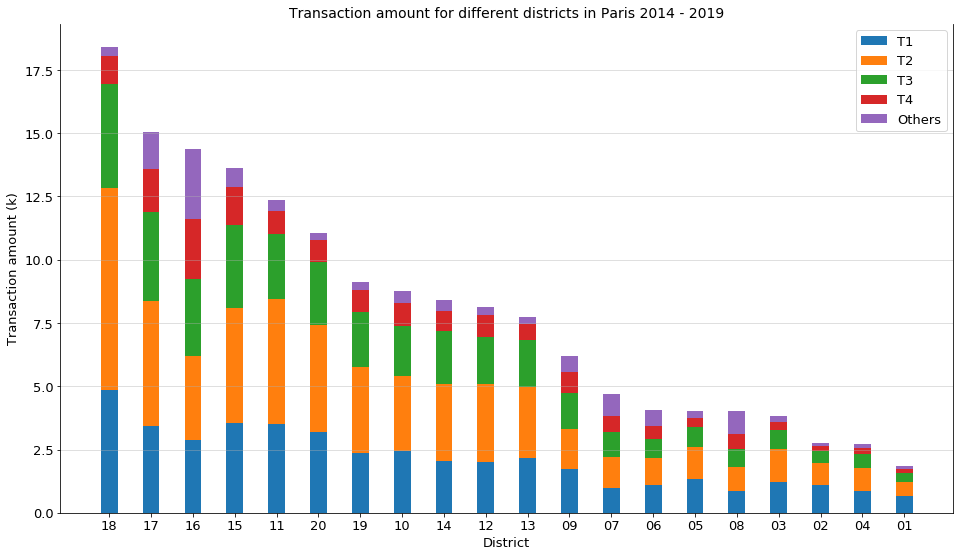

In [28]:
width = 0.4

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.set_title('Transaction amount for different districts in Paris 2014 - 2019',
                fontdict={'fontsize': 14})

rect1 = ax.bar(commune_piece_sales.arrondissement,
               commune_piece_sales.T1,
               width=width)
rect2 = ax.bar(commune_piece_sales.arrondissement,
               commune_piece_sales.T2,
               bottom=commune_piece_sales.T1,
               width=width)
rect3 = ax.bar(commune_piece_sales.arrondissement,
               commune_piece_sales.T3,
               bottom=commune_piece_sales.T1 + commune_piece_sales.T2,
               width=width)
rect4 = ax.bar(commune_piece_sales.arrondissement,
               commune_piece_sales.T4,
               bottom=commune_piece_sales.T1 + commune_piece_sales.T2 + commune_piece_sales.T3,
               width=width)
rect5 = ax.bar(commune_piece_sales.arrondissement,
               commune_piece_sales.Others,
               bottom=commune_piece_sales.T1 + commune_piece_sales.T2 + commune_piece_sales.T3 + commune_piece_sales.T4,
               width=width)

ax.tick_params(labelsize=13)
ax.set_xlabel('District', size=13)
ax.set_ylabel('Transaction amount (k)', size=13)

ax.grid(axis='y', which='major', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(formatter_thousands_1dec)
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]),
          ('T1', 'T2', 'T3', 'T4', 'Others'),
          fontsize=13)

plt.show()
# plt.savefig('unit_price_piece_number_district.png', bbox_inches='tight')

According to this map, we observe that the older apartments in districts 1, 4, 6, 7 and 8 are much more expensive that other districts, their average unit price is at least 11000 euros; on the contrary, the older apartments in districts 13, 18, 19 and 20 are much cheaper than others, their average unit price is less than 8000 euros. This might be caused by geographical positions, number of piece, apartment's state, performance of energy, public security, etc. The public transport in the city center is more than other areas, there are also lots of shopping centers or tourist spots, which attracts a great deal of people, so that make the city center to be more valuable. Then according to the stacked bar plot, it's obvious that there are much more transactions in 18th district than other areas, more than 50% sold apartment are 2-room or 3-room apartments, that's one of reasons why the unit price of 18th district is cheaper, same for 19th and 20th district; for the districts as 1st, 4th or 5th district, nearly one third of sold apartments are T1 apartments, which might be one of reasons why the unit price of these districts is more expensive.

## Relationship between area & apartment price for different districts

In [29]:
def scatter_area_price(ax, vf_75, district, title, col_nb=None, row_nb=None):
    ax.set_title(title, fontdict={'fontsize': 11})
    ax.scatter(x=vf_75[vf_75['nom_commune']==district].surface_reelle_bati,
               y=vf_75[vf_75['nom_commune']==district].valeur_fonciere,
               s=1, alpha=0.6, label=title)
    ax.plot([0, 210], [0, 2100000], color='tomato', linestyle='--')
    ax.set_ylim(bottom=0, top=2400000)
    ax.set_xlim(left=0, right=210)
    ax.yaxis.set_major_formatter(formatter_millions_1dec)
    
    if col_nb == 0:
        ax.set_ylabel('Price (million €)', size=11)
    else:
        ax.get_yaxis().set_ticklabels([])
    
    if row_nb == 3:
        ax.set_xlabel('Area (m2)', size=11)


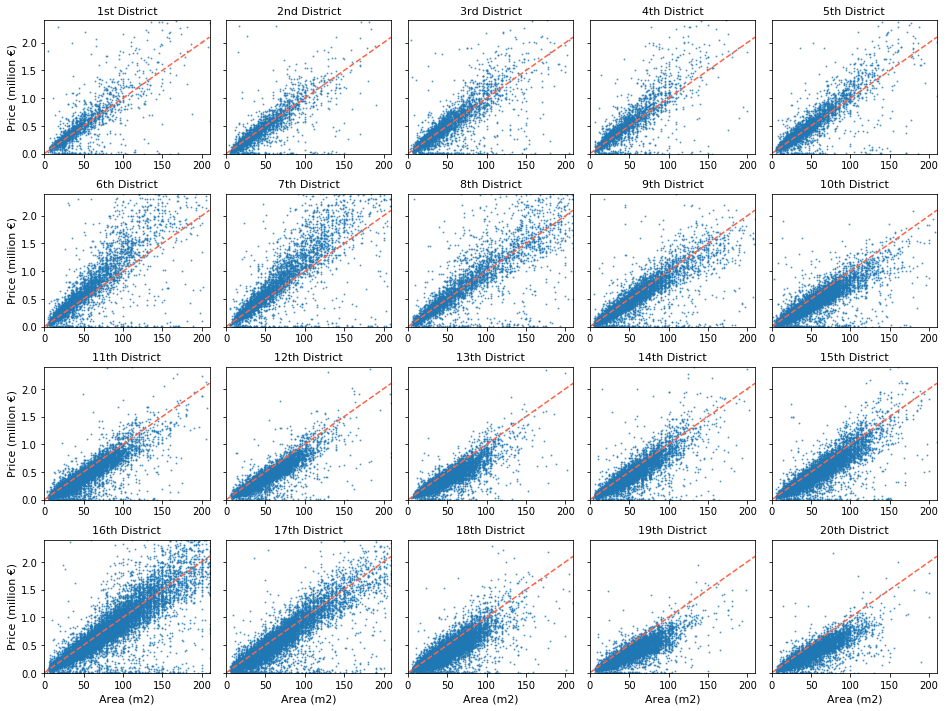

In [30]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(16, 12))

scatter_area_price(ax[0, 0], vf_75, district='Paris 1er Arrondissement', title='1st District', col_nb=0)
scatter_area_price(ax[0, 1], vf_75, district='Paris 2e Arrondissement', title='2nd District')
scatter_area_price(ax[0, 2], vf_75, district='Paris 3e Arrondissement', title='3rd District')
scatter_area_price(ax[0, 3], vf_75, district='Paris 4e Arrondissement', title='4th District')
scatter_area_price(ax[0, 4], vf_75, district='Paris 5e Arrondissement', title='5th District')

scatter_area_price(ax[1, 0], vf_75, district='Paris 6e Arrondissement', title='6th District', col_nb=0)
scatter_area_price(ax[1, 1], vf_75, district='Paris 7e Arrondissement', title='7th District')
scatter_area_price(ax[1, 2], vf_75, district='Paris 8e Arrondissement', title='8th District')
scatter_area_price(ax[1, 3], vf_75, district='Paris 9e Arrondissement', title='9th District')
scatter_area_price(ax[1, 4], vf_75, district='Paris 10e Arrondissement', title='10th District')

scatter_area_price(ax[2, 0], vf_75, district='Paris 11e Arrondissement', title='11th District', col_nb=0)
scatter_area_price(ax[2, 1], vf_75, district='Paris 12e Arrondissement', title='12th District')
scatter_area_price(ax[2, 2], vf_75, district='Paris 13e Arrondissement', title='13th District')
scatter_area_price(ax[2, 3], vf_75, district='Paris 14e Arrondissement', title='14th District')
scatter_area_price(ax[2, 4], vf_75, district='Paris 15e Arrondissement', title='15th District')

scatter_area_price(ax[3, 0], vf_75, district='Paris 16e Arrondissement', title='16th District', col_nb=0, row_nb=3)
scatter_area_price(ax[3, 1], vf_75, district='Paris 17e Arrondissement', title='17th District', row_nb=3)
scatter_area_price(ax[3, 2], vf_75, district='Paris 18e Arrondissement', title='18th District', row_nb=3)
scatter_area_price(ax[3, 3], vf_75, district='Paris 19e Arrondissement', title='19th District', row_nb=3)
scatter_area_price(ax[3, 4], vf_75, district='Paris 20e Arrondissement', title='20th District', row_nb=3)

plt.subplots_adjust(hspace=.3, wspace=.1)
plt.show()
# plt.savefig('area_price_district.png', bbox_inches='tight')

According to this group of scatter plots, we can simply get the relationship between older apartments' price and their area. Each point stands for one transaction, the plots on the red dash line mean that the price per m2 of these transactions is 10k euros. The points above the dash line indicate their unit price are greater than 10000 euros; otherwise, it's less than 10k euros per m2.

For the 1st, 2nd and 4th district, almost sold apartments are smaller than 50 m2, but their price per m2 varies widely to nearly 2 million euros; for the 8th, 16th and 17th district, almost sold apartments' price also arrive more than 2 million euros, but their area varies widely to 200 m2; moreover, there are also apartments whose unit price and area don't vary that widely, as in 13th, 18th, 19th and 20th district, most of apartments here are smaller than 100 m2 and cheaper than 1 million euros, so than less than 10k euros per m2.

## Time seris: seasonal decomposition

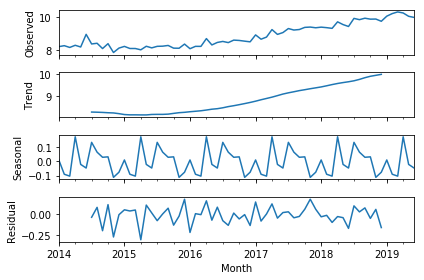

In [31]:
import statsmodels.api as sm
decomp_df = mth_df.copy()
decomp_df = decomp_df[['Month', 'avg_valeurK_m2']]
decomp_df['Month'] = pd.to_datetime(decomp_df['Month'])
decomp_df = decomp_df.set_index('Month')

dcpst = sm.tsa.seasonal_decompose(decomp_df)
fig = dcpst.plot()
matplotlib.rcParams['figure.figsize'] = [16.0, 10.0]
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['axes.labelsize'] = 15

I used Time Series `additive` model to decompose data into a trend component, a seasonal component and a residual component. The trand component captures changes over time, the seasonal component captures cyclical effects due to the time of year, the residual component captures the influences not describes by the trend and seasonal effects. Thanks to this model, we find that except for July, there are another transaction peak in April, which we didn't find above. In March and November, the transactions arrive their low points, that might because during the transition period between 2 years, the desire for purchasing or selling apartments is not that high.

## Time series: prediction on monthly price

In [32]:
mth_prophet = mth_df[6:].copy()
mth_prophet = mth_prophet.drop(columns='nb_mutation')
mth_prophet = mth_prophet.rename(columns={'Month': 'ds', 'avg_valeurK_m2': 'y'})

In [33]:
import fbprophet

# Make the prophet model and fit on the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
gm_prophet.fit(mth_prophet)

# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=12 * 5, freq='m')# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


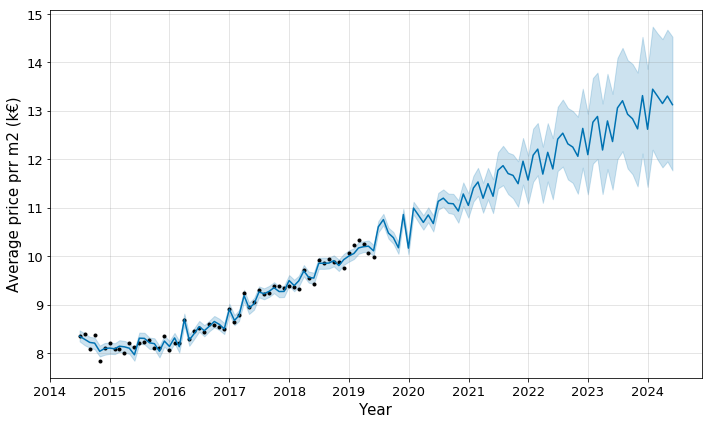

In [34]:
gm_prophet.plot(gm_forecast, xlabel = 'Year', ylabel = 'Average price prr m2 (k€)')
# plt.savefig('price_prediction.png', bbox_inches='tight')

The blacks points present actual values, the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty. The uncertainty's region increases for the prediction because of the initial uncertainty and it grows over time. This can be impacted by policy, social elements, or some others.